In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import metpy
import requests
import matplotlib.pyplot as pl
import matplotlib.patheffects as pe
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from metpy.plots import ctables
from osgeo import osr
import datetime
from wradlib.io.xarray import CfRadial, OdimH5

import urllib
import io
import glob

try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

from html.parser import HTMLParser

class DWDHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag != 'a':
            return
        self.links.append(attrs[0][1])

parser = DWDHTMLParser()

In [2]:
opendata_url1 = (f"https://opendata.dwd.de/weather/radar/radvor/rq/")
with urllib.request.urlopen(opendata_url1) as url_request:
    response = url_request.read().decode("utf-8")

parser.links = []
parser.feed(response)
filelist1 = parser.links[1:]
filelist1.sort()
filelist1.reverse()

#print(filelist1)

for f in filelist1[:2]:
    urllib.request.urlretrieve(os.path.join(opendata_url1, f), f)
    
radfile = wrl.util.get_wradlib_data_file('/home/lmathias/Documents/wradlib/nhb/radvor/' + f)
rvdata, rvattrs = wrl.io.read_radolan_composite(radfile)

print("Radvor Attributes:", rvattrs)

sec = rvattrs['secondary']
rvdata.flat[sec] = -9999
rvdata = np.ma.masked_equal(rvdata, -9999)
rvdata = np.ma.masked_where(rvdata <=0,rvdata)
rvdata_01 = np.where(rvdata>=0.1, 0.1, rvdata)
rvdata_01 = np.ma.masked_where(rvdata_01 <0.1,rvdata_01)
rvdata_5 = np.where(rvdata>=5, 5, rvdata)
rvdata_5 = np.ma.masked_where(rvdata_5 <5,rvdata_5)
rvdata_10 = np.where(rvdata>=10, 5, rvdata)
rvdata_10 = np.ma.masked_where(rvdata_10 <10,rvdata_10)

from osgeo import osr
proj_stereo = wrl.georef.create_osr("dwd-radolan")
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(3857)

radolan_grid_xy = wrl.georef.get_radolan_grid(900,900)
radolan_grid_ll = wrl.georef.reproject(radolan_grid_xy, projection_source=proj_stereo, projection_target=proj_wgs)
print("{0}, ({1:.4f}, {2:.4f})".format(radolan_grid_ll.shape, *radolan_grid_ll[0,0,:]))

lon = radolan_grid_ll[:, :, 0]
lat = radolan_grid_ll[:, :, 1]

time = rvattrs['datetime'].isoformat()

import dateutil.parser
time = dateutil.parser.parse(time)
time2 = time.strftime("%Y%m%d%H%M")
time3 = time+datetime.timedelta(hours=1)
time4 = time3.strftime("%Y%m%d%H%M")
print(time2)

Radvor Attributes: {'producttype': 'RQ', 'datetime': datetime.datetime(2021, 9, 10, 23, 15), 'radarid': '10000', 'datasize': 1620000, 'maxrange': '150 km', 'radolanversion': '2.29.1', 'precision': 0.1, 'intervalseconds': 3600, 'nrow': 900, 'ncol': 900, 'radarlocations': ['asb', 'boo', 'drs', 'eis', 'ess', 'fbg', 'fld', 'hnr', 'isn', 'mem', 'neu', 'nhb', 'oft', 'pro', 'ros', 'tur', 'umd'], 'predictiontime': 60, 'moduleflag': 8, 'quantification': 0, 'nodataflag': -9999, 'secondary': array([], dtype=int64), 'nodatamask': array([     0,      1,      2, ..., 809997, 809998, 809999]), 'cluttermask': array([], dtype=int64)}
(900, 900, 2), (399517.8546, 5934337.4204)
202109102315


dwd_rq_202109102315.jpeg


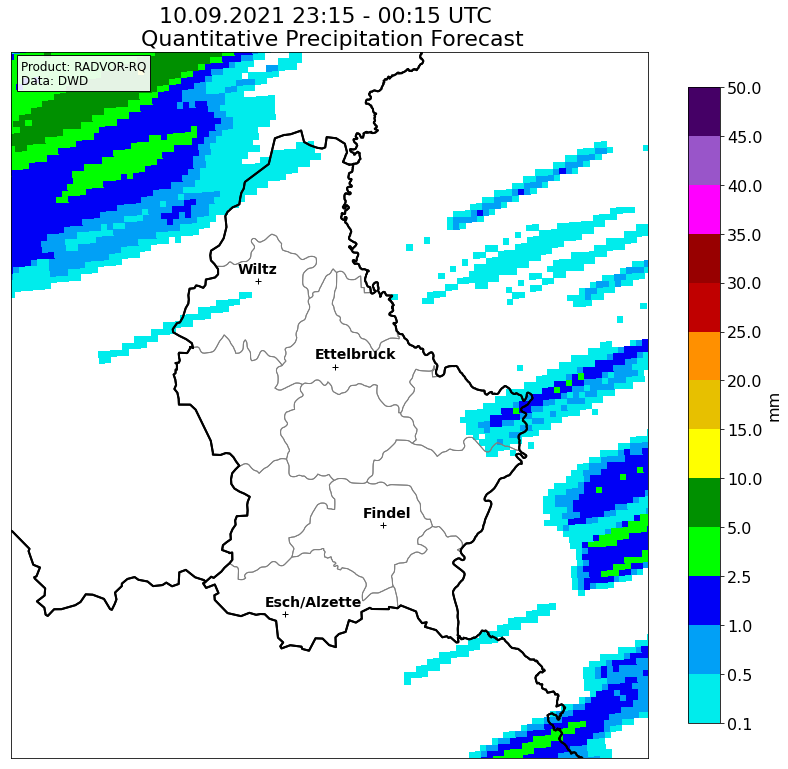

In [4]:
#pl.rcParams["font.family"] = "Liberation Sans"

def plot_borders2(ax):
    filename = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_0.shp')
    filename3 = wrl.util.get_wradlib_data_file('geo/gadm36_BEL_0.shp')
    filename4 = wrl.util.get_wradlib_data_file('geo/gadm36_FRA_0.shp')
    filename5 = wrl.util.get_wradlib_data_file('geo/gadm36_DEU_0.shp')
    dataset, inLayer = wrl.io.open_vector(filename)
    dataset3, inLayer3 = wrl.io.open_vector(filename3)
    dataset4, inLayer4 = wrl.io.open_vector(filename4)
    dataset5, inLayer5 = wrl.io.open_vector(filename5)
    borders, keys = wrl.georef.get_vector_coordinates(inLayer,dest_srs=proj_wgs)
    borders3, keys3 = wrl.georef.get_vector_coordinates(inLayer3,dest_srs=proj_wgs)
    borders4, keys4 = wrl.georef.get_vector_coordinates(inLayer4,dest_srs=proj_wgs)
    borders5, keys5 = wrl.georef.get_vector_coordinates(inLayer5,dest_srs=proj_wgs)
    wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders3, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders4, color='black', lw=2, zorder=4)
    wrl.vis.add_lines(ax, borders5, color='black', lw=2, zorder=4)
    
def plot_cant(ax):
    filename6 = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_2.shp')
    dataset6, inLayer6 = wrl.io.open_vector(filename6)
    borders6, keys6 = wrl.georef.get_vector_coordinates(inLayer6,dest_srs=proj_wgs)
    wrl.vis.add_lines(ax, borders6, color='grey', lw=1, zorder=4)
    
def plot_cities(ax):
    lats = [6420338.89,6381784.16,6360130.74,6441081.99]
    lons = [679048.89,690575.69,666803.75,660124.58]
    cities = ['Ettelbruck','Findel','Esch/Alzette','Wiltz']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'k+', zorder=5)
        ax.text(lon - 5000, lat + 2000, city, fontsize='14', fontweight='bold', 
                 color='black', zorder=5)

cmap = ctables.colortables.get_colortable('NWSReflectivity')
colors1=[(0.0, 0.9254901960784314, 0.9254901960784314), 
                    (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (1.0, 1.0, 0.0)]
colors=[(0.0, 0.9254901960784314, 0.9254901960784314), 
                    (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 1.0, 0.0), 
                    (0.0, 0.7843137254901961, 0.0), 
                    (0.0, 0.5647058823529412, 0.0), 
                    (1.0, 1.0, 0.0), 
                    (0.9058823529411765, 0.7529411764705882, 0.0), 
                    (1.0, 0.5647058823529412, 0.0), 
                    (1.0, 0.16078431372, 0.16078431372), 
                    (0.7529411764705882, 0.0, 0.0),
                    (0.59765625, 0.0, 0.0), 
                    (1.0, 0.0, 1.0), 
                    (0.6, 0.3333333333333333, 0.788235294117647),
                     (0.27,0,0.4)]
cmap1 = ListedColormap(colors)

newcmap = ListedColormap(cmap1(np.linspace(0, 1, 16)))
bounds = [0.1,0.5,1,2.5,5,10,15,20,25,30,35,40,45,50]
norm = BoundaryNorm(bounds, newcmap.N)

fig = pl.figure(figsize=(14.5,13))
ax = fig.add_subplot(111, aspect="equal")
#pm = ax.pcolormesh(lon, lat, rvdata_01, cmap=newcmap, vmin=0.1, vmax=7)
#pm2 = ax.pcolormesh(lon, lat, rvdata_5, cmap=newcmap, vmin=0.1, vmax=7)
pm = ax.pcolormesh(lon, lat, rvdata, cmap=newcmap, norm=norm)
cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=(0.1,0.5,1,2.5,5,10,15,20,25,30,35,40,45,50),orientation='vertical')
cb.set_label("mm",fontsize=16)
cb.ax.tick_params(labelsize=16)
pl.xlim(0.60*1e6,0.755*1e6)
pl.ylim(6.325*1e6,6.497*1e6)
pl.xticks([])
pl.yticks([])
plot_cant(ax)
plot_borders2(ax)
plot_cities(ax)
t=pl.gcf().text(0.145, 0.845, 'Product: RADVOR-RQ\nData: DWD', fontsize=12)
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))
pl.title(time.strftime("%d.%m.%Y %H:%M - ")+time3.strftime("%H:%M UTC \n Quantitative Precipitation Forecast"), fontsize=22)
base_filename='dwd_rq_'
suffix='.jpeg'
latest='latest'
my_file = base_filename+time2+suffix
print(my_file)
pl.savefig(my_file, bbox_inches='tight', dpi=85)